<a href="https://colab.research.google.com/github/chiss7/mnist-tensorflow/blob/main/MNIST1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/Colab Notebooks/Números MNIST - Tensorflow 2 (no keras)/utils.py' '/content'
!cp '/content/drive/MyDrive/Colab Notebooks/Números MNIST - Tensorflow 2 (no keras)/optimizers.py' '/content'
!cp '/content/drive/MyDrive/Colab Notebooks/Números MNIST - Tensorflow 2 (no keras)/export.py' '/content'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as sk_metrics

import os

from utils import Model
from optimizers import GradientDescent, Momentum, Adam
from export import ExportModule

# Refreshing import to changes in utils.py
%load_ext autoreload
%autoreload 2

# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# Set random seed for reproducible results
tf.random.set_seed(22)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.14.0


In [12]:
train_data, val_data, test_data = tfds.load("mnist", split=['train[10000:]', 'train[0:10000]', 'test'], batch_size=128, as_supervised=True)

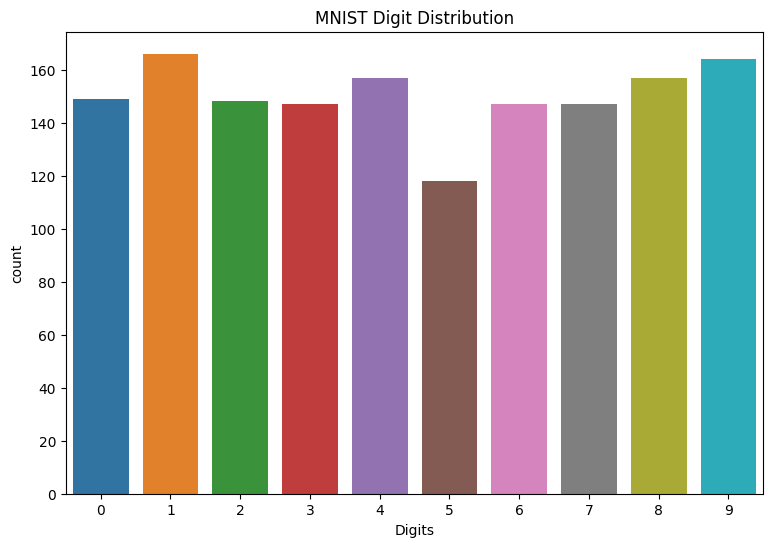

In [13]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
sns.countplot(x=y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

In [14]:
for i, j in train_data.take(1):
  print(i.shape, j.shape)

(128, 28, 28, 1) (128,)


In [15]:
def preprocess(x, y):
  # Reshaping the data (reshape the feature matrices to be 2-dimensional by flattening the images)
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data (ensures that the input pixels have similar distributions and helps with training convergence.)
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

In [16]:
for i, y in train_data.take(1):
  print(i.shape, y.shape)

(128, 784) (128,)


In [17]:
# HYPER PARAMETERS
lr = 1e-3
arch = [700, 500]
num_epochs = 10

model = Model(arch)
optimizer = Adam(learning_rate=lr)

loss_list = []
accuracy_list = []
val_loss_list = []
val_accuracy_list = []

print("----------------------------------------")
print(model.title)
print(optimizer.title)
print("----------------------------------------")

# TRAIN MODEL
for epoch in range(num_epochs):

  batch_losses_train, batch_accs_train = [], []
  batch_losses_val, batch_accs_val = [], []

  print("Train Data [", end="")

  # Iterate over the training data
  for X_train_batch, y_train_batch in train_data:
    # Compute gradients and update the model's parameters
    with tf.GradientTape() as t:
      # Batch Loss
      y_pred = model(X_train_batch)
      batch_loss = model.cross_entropy_loss(y_pred, y_train_batch)
    # Batch Accuracy
    batch_acc = model.compute_accuracy(y_pred, y_train_batch)

    grads = t.gradient(batch_loss, model.Variables)

    # Apply Gradients (optimizer)
    model.Variables = optimizer.apply_gradients(model.Variables, grads)

    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  print("✔] ", end="")

  print("Val Data [", end="")
  # Iterate over the validation data
  for X_val_batch, y_val_batch in val_data:
    # Evaluate the model on given a batch of validation data
    y_pred = model(X_val_batch)
    batch_loss = model.cross_entropy_loss(y_pred, y_val_batch)
    batch_acc = model.compute_accuracy(y_pred, y_val_batch)
    # Keep track of batch-level validation performance
    batch_losses_val.append(batch_loss)
    batch_accs_val.append(batch_acc)

  print("✔] ", end="")

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)

  loss_list.append(train_loss)
  val_loss_list.append(val_loss)
  accuracy_list.append(train_acc)
  val_accuracy_list.append(val_acc)

  print(f"Epoch: {epoch}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {train_acc:.3f}, Val Accuracy: {val_acc:.3f}")

----------------------------------------
Model architecture -> input[28x28], hiddenListWrapper([700, 500]), output[10]
Adam: learning rate = 0.001
----------------------------------------
Train Data [✔] Val Data [✔] Epoch: 0, Loss: 0.2226, Val Loss: 0.1216, Accuracy: 0.934, Val Accuracy: 0.963
Train Data [✔] Val Data [✔] Epoch: 1, Loss: 0.0798, Val Loss: 0.1038, Accuracy: 0.975, Val Accuracy: 0.969
Train Data [✔] Val Data [✔] Epoch: 2, Loss: 0.0464, Val Loss: 0.0921, Accuracy: 0.986, Val Accuracy: 0.975
Train Data [✔] Val Data [✔] Epoch: 3, Loss: 0.0352, Val Loss: 0.0984, Accuracy: 0.989, Val Accuracy: 0.975
Train Data [✔] Val Data [✔] Epoch: 4, Loss: 0.0257, Val Loss: 0.1035, Accuracy: 0.992, Val Accuracy: 0.973
Train Data [✔] Val Data [✔] Epoch: 5, Loss: 0.0218, Val Loss: 0.0952, Accuracy: 0.993, Val Accuracy: 0.978
Train Data [✔] Val Data [✔] Epoch: 6, Loss: 0.0200, Val Loss: 0.0919, Accuracy: 0.993, Val Accuracy: 0.978
Train Data [✔] Val Data [✔] Epoch: 7, Loss: 0.0193, Val Loss: 0

**Show Loss and Accuracy**


In [33]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

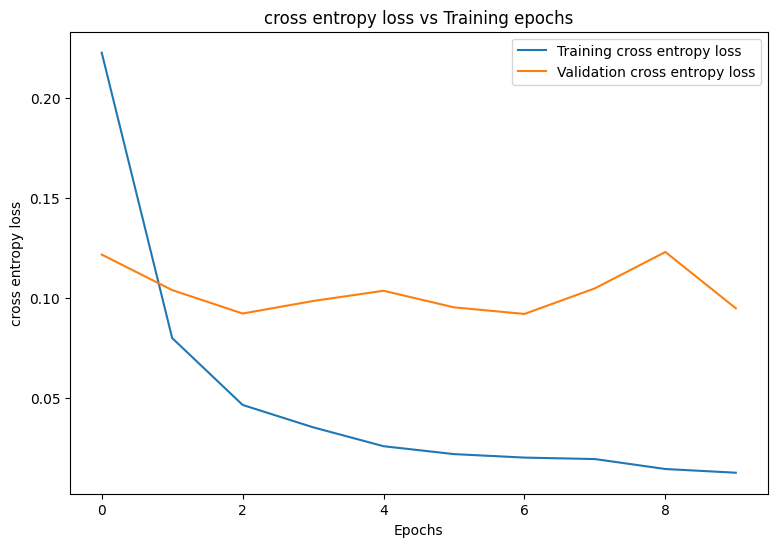

In [34]:
plot_metrics(loss_list, val_loss_list, "cross entropy loss")

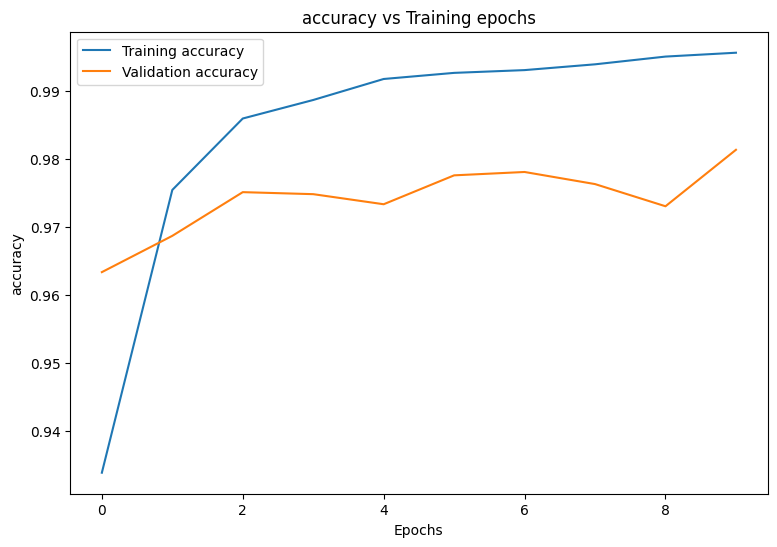

In [35]:
plot_metrics(accuracy_list, val_accuracy_list, "accuracy")

**Save and Load Model**

In [36]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = tf.reshape(x, shape=[-1, 784])
  x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)

In [37]:
mnist_model_export = ExportModule(model=model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [38]:
save_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Números MNIST - Tensorflow 2 (no keras)/models', 'mlp_model_export')
tf.saved_model.save(mnist_model_export, save_path)

In [39]:
mnist_loaded = tf.saved_model.load(save_path)

In [40]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mnist_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.982


In [41]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 9: 0.968
Digit 8: 0.974
Digit 3: 0.975
Digit 6: 0.978
Digit 7: 0.982
Digit 4: 0.983
Digit 5: 0.987
Digit 0: 0.987
Digit 2: 0.990
Digit 1: 0.995


**Confusion Matrix**

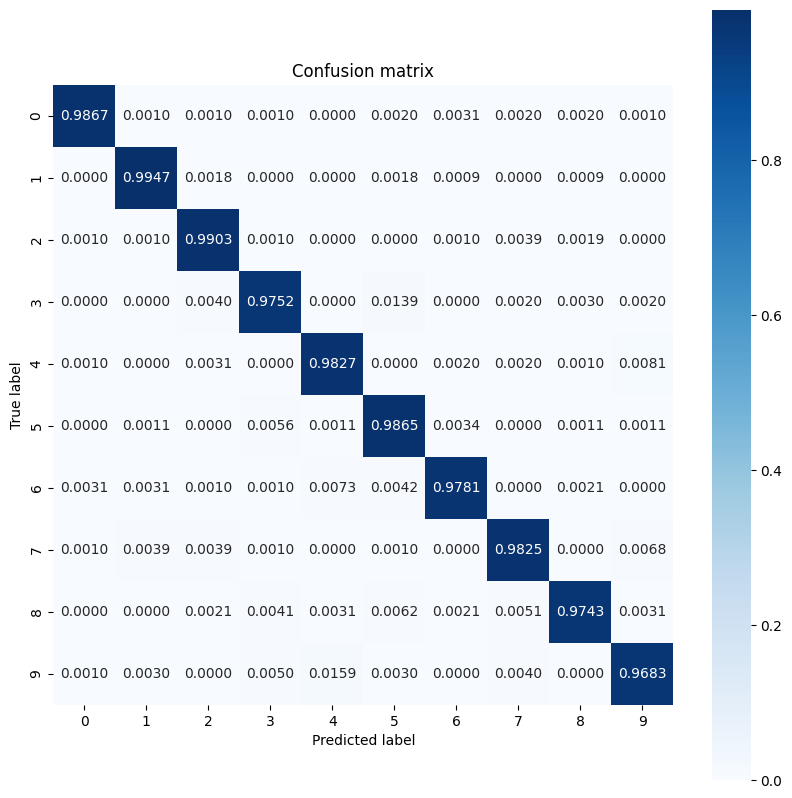

In [42]:
def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels.numpy(),
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_test, test_classes)